## Imports

In [260]:
import tensorflow
from tensorflow import keras
import matplotlib
import numpy as np
import pandas as pd
from os import listdir
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

## Load Data

#### Plot Image

In [261]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

##### Load images from data folder, preproccess, color to RGB and convert to numpy array

In [262]:
def load_images(directory):
    images = []
    target_shape = (128, 128)  # Specify the desired shape

    for file in listdir(directory):
        filename = directory + "/" + file
        print(filename)
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_shape)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        # plot_image(image)
        image = np.asanyarray(image)
        print(image.shape)
        images.append(image)
    return np.asarray(images)

In [263]:
images = load_images("data/images")

data/images/flickr_dog_000002.jpg
(128, 128, 3)
data/images/flickr_dog_000003.jpg
(128, 128, 3)
data/images/flickr_dog_000004.jpg
(128, 128, 3)
data/images/flickr_dog_000005.jpg
(128, 128, 3)
data/images/flickr_dog_000006.jpg
(128, 128, 3)
data/images/flickr_dog_000007.jpg
(128, 128, 3)
data/images/flickr_dog_000008.jpg
(128, 128, 3)
data/images/flickr_dog_000009.jpg
(128, 128, 3)
data/images/flickr_dog_000010.jpg
(128, 128, 3)
data/images/flickr_dog_000011.jpg
(128, 128, 3)
data/images/flickr_dog_000012.jpg
(128, 128, 3)
data/images/flickr_dog_000013.jpg
(128, 128, 3)
data/images/flickr_dog_000014.jpg
(128, 128, 3)
data/images/flickr_dog_000015.jpg
(128, 128, 3)
data/images/flickr_dog_000016.jpg
(128, 128, 3)
data/images/flickr_dog_000017.jpg
(128, 128, 3)
data/images/flickr_dog_000018.jpg
(128, 128, 3)
data/images/flickr_dog_000019.jpg
(128, 128, 3)
data/images/flickr_dog_000020.jpg
(128, 128, 3)
data/images/flickr_dog_000021.jpg
(128, 128, 3)
data/images/flickr_dog_000022.jpg
(128, 

## Descriminator

In [264]:
def discriminator(in_shape=(128,128,3)):
    disc = Sequential()
    disc.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Flatten())
    disc.add(Dropout(0.4))
    disc.add(Dense(1, activation="sigmoid"))
    opt = Adam(learning_rate=0.0002, beta_1= 0.5)
    disc.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return disc

In [265]:
disc = discriminator()
disc.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 64)      

## Generator

In [266]:
def generator(latent_dim):
    gen = Sequential()

    n_nodes = 256*8*8
    gen.add(Dense(n_nodes, input_dim=latent_dim))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(Reshape((8,8,256)))

    # Upsample to 16x16
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))

    # Upsample to 32x32
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))

    # Upsample to 64x64
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))

    # Upsample to 128x128
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))

    gen.add(Conv2D(3,(7,7), activation='tanh', padding='same'))
    return gen

In [267]:
gen = generator(100)
gen.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 16, 16, 128)      524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                          

## Create GAN

In [268]:
def create_GAN(gen, disc):
    disc.trainable = False
    GAN = Sequential()
    GAN.add(gen)
    GAN.add(disc)
    opt = Adam(learning_rate=0.0002, beta_1= 0.5)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    return GAN

In [269]:
GAN = create_GAN(gen, disc)
GAN.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 128, 128, 3)       2984835   
                                                                 
 sequential_27 (Sequential)  (None, 1)                 153601    
                                                                 
Total params: 3,138,436
Trainable params: 2,984,835
Non-trainable params: 153,601
_________________________________________________________________


In [270]:
def load_real_images():
    datagen = ImageDataGenerator(rescale=1./255)
    X = datagen.flow_from_directory('data', target_size=(128,128), batch_size=12500, class_mode='binary')
    data_list = []
    batch_index = 0
    while batch_index <= X.batch_index:
        data = X.next()
        data_list.append(data[0])
        batch_index += 1
    img_array = np.asarray(data_list)
    return img_array
    

In [271]:
def generate_real_images(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    y = np.ones((n_samples,1))
    return X,y

In [272]:
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples)
    X = X.reshape(n_samples, latent_dim)
    return X

In [273]:
def generate_fake_images(gen, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim , n_samples)
    X = gen.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X,y

In [274]:
def summerize_performance(epoch, gen, disc, dataset, latent_dim, n_samples=100):
    gen.save('/models/model_dog_' + str(epoch) + '.h5')
    X_real, y_real = generate_real_images(dataset, n_samples)
    _, acc_real = disc.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_images(gen, latent_dim, n_samples)
    _, acc_fake = disc.evaluate(X_fake, y_fake, verbose=0)
    print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [275]:
def train_GAN(gen, disc, GAN, dataset, latent_dim, n_epochs=100, n_batch=128):
    batch_per_epoch = int(dataset.shape[0] / n_batch)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_images(dataset, n_batch)
            X_fake, y_fake = generate_fake_images(gen, latent_dim, n_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = disc.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = GAN.train_on_batch(X_gan, y_gan)

            print('epoch: %d, batch: %d/%d, d_loss=%.3f. g_loss=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summerize_performance(i, gen, disc, dataset, latent_dim)


In [276]:
latent_dim = 100
disc = discriminator()
gen = generator(latent_dim)
GAN = create_GAN(gen, disc)
dataset = load_real_images()

Found 6397 images belonging to 2 classes.


In [277]:
train_GAN(gen, disc, GAN, dataset[0], latent_dim)

4/4 [==============================] - 4s 864ms/step
epoch: 1, batch: 1/49, d_loss=0.694. g_loss=0.693
4/4 [==============================] - 3s 741ms/step
epoch: 1, batch: 2/49, d_loss=0.681. g_loss=0.693
4/4 [==============================] - 3s 759ms/step
epoch: 1, batch: 3/49, d_loss=0.667. g_loss=0.693
4/4 [==============================] - 3s 752ms/step
epoch: 1, batch: 4/49, d_loss=0.651. g_loss=0.692
4/4 [==============================] - 3s 729ms/step
epoch: 1, batch: 5/49, d_loss=0.631. g_loss=0.688
4/4 [==============================] - 3s 743ms/step
epoch: 1, batch: 6/49, d_loss=0.609. g_loss=0.677
4/4 [==============================] - 3s 741ms/step
epoch: 1, batch: 7/49, d_loss=0.583. g_loss=0.644
4/4 [==============================] - 3s 741ms/step
epoch: 1, batch: 8/49, d_loss=0.578. g_loss=0.561
4/4 [==============================] - 3s 743ms/step
epoch: 1, batch: 9/49, d_loss=0.657. g_loss=0.442
4/4 [==============================] - 3s 743ms/step
epoch: 1, batch: 10/

In [278]:
GAN.save('GAN_model.h5')
disc.save('disc_model.h5')

In [279]:
gen.save('gen_model.h5')

In [280]:
gen = load_model('gen_model.h5')
gen.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_7 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 16, 16, 128)      524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_92 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                          

In [286]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_images(images, n):
    images = (images - images.min()) / (images.max() - images.min())
    fig, axes = plt.subplots(1, n, figsize=(300, 300))  # Adjust figsize as needed
    for i in range(n):
        img = np.squeeze(images[i])  # Remove any single-dimensional axes
        axes[i].imshow(img, cmap='gray')  # Add cmap='gray' for grayscale images
        axes[i].axis('off')

        # Save the image
        save_path = os.path.join('generated_images', f'image_{i+1}.png')  # Adjust the file format if needed
        plt.imsave(save_path, img, cmap='gray')  # Save the image as grayscale
    plt.show()

1/1 [==============================] - 1s 874ms/step


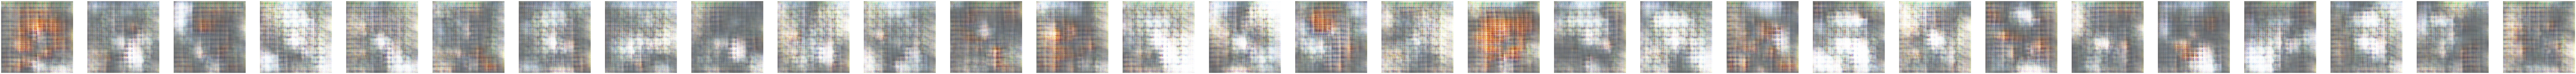

array([[[[0.27586067, 0.39681867, 0.23825878],
         [0.4545001 , 0.48284626, 0.30726236],
         [0.45340014, 0.4706727 , 0.4080186 ],
         ...,
         [0.44790813, 0.39584494, 0.304819  ],
         [0.35136405, 0.40168697, 0.2653022 ],
         [0.41813698, 0.41351104, 0.3435573 ]],

        [[0.37014565, 0.4109628 , 0.24477862],
         [0.4196708 , 0.44840726, 0.25696558],
         [0.5374193 , 0.5149423 , 0.38044056],
         ...,
         [0.3472161 , 0.40794635, 0.37444338],
         [0.3728789 , 0.5125593 , 0.3668743 ],
         [0.40199977, 0.3971918 , 0.31808886]],

        [[0.38263676, 0.4082473 , 0.17212355],
         [0.4524341 , 0.42513713, 0.21993087],
         [0.51632774, 0.49898148, 0.2928218 ],
         ...,
         [0.4000374 , 0.48110735, 0.3636351 ],
         [0.4319219 , 0.5133171 , 0.3481491 ],
         [0.40851513, 0.5068255 , 0.34628642]],

        ...,

        [[0.20281786, 0.24221875, 0.15796827],
         [0.20518044, 0.17543839, 0.22737597]

In [291]:
pts = generate_latent_points(100, 30)
X = gen.predict(pts)
plot_images(X, 30)
X